<a href="https://colab.research.google.com/github/satyajitghana/PadhAI-Course/blob/master/20_HyperparameterTuning_MLFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Outline

1.   Basic motivation of hyperparameter tuning
2.   Integrating Google colab with a local runtime (config in Google colab, Browser, Jupyter notebook)
3.   Installing MLFlow and basic use case
4.   Logging parameters, metrics with MLFlow
5.   Logging image artifacts with MLFlow
6.   Logging PyTorch models with MLFlow and loading them


## Run in local instance (same folder as the notebook)
```python
pip install jupyter_http_over_ws
jupyter serverextension enable --py jupyter_http_over_ws

jupyter notebook \
  --NotebookApp.allow_origin='https://colab.research.google.com' \
  --port=8888 \
  --NotebookApp.port_retries=0
```

``conda install -c pytorch pytorch``

``conda install -c conda-forge mlflow``

``conda install -c pytorch torchvision``

In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np

import torchvision
from torchvision import datasets, transforms

import torch.nn as nn
import torch.optim as optim
import seaborn as sns
sns.set()

In [0]:
import mlflow
import mlflow.pytorch

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Params

In [0]:
class Params(object):
    def __init__(self, batch_size, epochs, seed, log_interval):
        self.batch_size = batch_size
        self.epochs = epochs
        self.seed = seed
        self.log_interval = log_interval

args = Params(256, 4, 0, 20)

# Dataset

In [0]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_set = datasets.MNIST('./data', train=True, download=True, 
                         transform=transform)

test_set = datasets.MNIST('./data', train=False, download=True, 
                         transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=args.batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=args.batch_size, shuffle=False)

# Model

In [0]:
class Model(nn.Module):
    def __init__(self, nH = 32): 
        super(Model, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(784, nH),  # 28 x 28 = 784
            nn.ReLU(),
            nn.Linear(nH, 10)
        )
             
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [0]:
def train(epoch):
    
    model.train()
    
    for batch_id, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        opt.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if batch_id % args.log_interval == 0:
            pos = epoch * len(train_loader) + batch_id
            mlflow.log_metric('train_loss', loss.data.item()/len(inputs)*1000)
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.3f}'.format(
                epoch, batch_id * len(inputs), len(train_loader.dataset),
                100. * batch_id / len(train_loader), loss.data.item()))
            
        del inputs, labels

In [0]:
def test(epoch):
    
    model.eval()
    test_loss = 0
    correct = 0
    confusion_matrix = np.zeros([10, 10])
    
    with torch.no_grad():
        
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_loss += loss_fn(outputs, labels).data.item()
            pred = outputs.data.max(1)[1]
            correct += pred.eq(labels.data).sum().item()
            
            for x, y in zip(pred.cpu().data.numpy(), labels.cpu().data.numpy()):
                confusion_matrix[x][y] += 1
            
        test_loss /= len(test_loader.dataset)
        test_accuracy = 100.0 * correct / len(test_loader.dataset)
        
        pos = (epoch + 1) * len(train_loader)
        mlflow.log_metric('test_loss', test_loss*1000)
        mlflow.log_metric('test_accuracy', test_accuracy)
        
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.
              format(test_loss, correct, len(test_loader.dataset), test_accuracy))
              
        if epoch == args.epochs:
            classes = np.arange(10)
            fig, ax = plt.subplots()
            im = ax.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
            ax.figure.colorbar(im, ax=ax)
            ax.set(xticks=np.arange(confusion_matrix.shape[1]),
                       yticks=np.arange(confusion_matrix.shape[0]),
                       xticklabels=classes, yticklabels=classes,
                       ylabel='True label',
                       xlabel='Predicted label',
                       title='Epoch %d' % epoch)
            thresh = confusion_matrix.max() / 2.
            for i in range(confusion_matrix.shape[0]):
                for j in range(confusion_matrix.shape[1]):
                    ax.text(j, i, int(confusion_matrix[i, j]),
                            ha="center", va="center",
                            color="white" if confusion_matrix[i, j] > thresh else "black")
              
            fig.tight_layout()
              
            image_path = './images/%s.png' % (expt_id)
            plt.savefig(image_path)
            mlflow.log_artifact(image_path)
            

# Hyperparameter tuning loop

INFO: 'Fixed nH' does not exist. Creating a new experiment

LR = 0.01, Momentum = 0.90, Hidden nodes = 48

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.379
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.257
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.617
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.386
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.359
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.321
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.356
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.330
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.352
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.396
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.243
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.272

Test set: Average loss: 0.0011, Accuracy: 9216/10000 (92%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.308
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.227
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.199
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.251
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.302
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.229


C:\Users\shadowleaf\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\shadowleaf\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\shadowleaf\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\shadowleaf\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be che


LR = 0.01, Momentum = 0.95, Hidden nodes = 48

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.342
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.803
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.420
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.329
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.450
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.222
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.291
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.306
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.178
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.314
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.370
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.178

Test set: Average loss: 0.0009, Accuracy: 9313/10000 (93%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.204
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.225
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.261
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.193
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.164
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.213
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.244
Train Epoch:

C:\Users\shadowleaf\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\shadowleaf\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\shadowleaf\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\shadowleaf\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be che


LR = 0.01, Momentum = 0.99, Hidden nodes = 48

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.350
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.813
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.744
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.561
Train Epoch: 1 [20480/60000 (34%)]	Loss: 1.004
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.421
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.395
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.486
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.420
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.426
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.513
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.328

Test set: Average loss: 0.0011, Accuracy: 9238/10000 (92%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.335
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.259
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.296
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.243
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.227
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.158
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.198
Train Epoch:

C:\Users\shadowleaf\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\shadowleaf\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\shadowleaf\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\shadowleaf\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be che


LR = 0.02, Momentum = 0.90, Hidden nodes = 48

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.369
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.630
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.483
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.277
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.293
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.243
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.300
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.348
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.237
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.298
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.261
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.294

Test set: Average loss: 0.0009, Accuracy: 9363/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.257
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.207
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.258
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.210
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.109
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.243
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.177
Train Epoch:

C:\Users\shadowleaf\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\shadowleaf\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\shadowleaf\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\shadowleaf\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be che


LR = 0.02, Momentum = 0.95, Hidden nodes = 48

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.331
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.590
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.421
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.416
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.345
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.423
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.249
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.253
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.287
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.163
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.232
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.091

Test set: Average loss: 0.0007, Accuracy: 9417/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.139
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.221
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.131
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.157
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.220
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.135
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.175
Train Epoch:

C:\Users\shadowleaf\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\shadowleaf\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\shadowleaf\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\shadowleaf\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be che


LR = 0.02, Momentum = 0.99, Hidden nodes = 48

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.334
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.621
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.926
Train Epoch: 1 [15360/60000 (26%)]	Loss: 1.275
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.819
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.578
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.866
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.443
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.377
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.704
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.421
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.404

Test set: Average loss: 0.0017, Accuracy: 8950/10000 (90%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.397
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.504
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.368
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.333
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.226
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.287
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.445
Train Epoch:

C:\Users\shadowleaf\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\shadowleaf\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\shadowleaf\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\shadowleaf\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be che


LR = 0.05, Momentum = 0.90, Hidden nodes = 48

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.358
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.471
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.335
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.346
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.353
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.268
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.197
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.243
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.221
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.241
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.137
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.181

Test set: Average loss: 0.0006, Accuracy: 9528/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.104
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.181
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.146
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.088
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.084
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.131
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.154
Train Epoch:

C:\Users\shadowleaf\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\shadowleaf\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\shadowleaf\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\shadowleaf\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be che


LR = 0.05, Momentum = 0.95, Hidden nodes = 48

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.319
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.570
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.689
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.371
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.274
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.221
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.164
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.282
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.141
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.113
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.137
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.174

Test set: Average loss: 0.0006, Accuracy: 9512/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.156
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.121
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.132
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.181
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.168
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.090
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.119
Train Epoch:

C:\Users\shadowleaf\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\shadowleaf\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\shadowleaf\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\shadowleaf\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be che


LR = 0.05, Momentum = 0.99, Hidden nodes = 48

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.352
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.852
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.930
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.921
Train Epoch: 1 [20480/60000 (34%)]	Loss: 1.330
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.677
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.610
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.782
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.505
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.542
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.891
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.488

Test set: Average loss: 0.0026, Accuracy: 8436/10000 (84%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.414
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.551
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.860
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.516
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.667
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.647
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.703
Train Epoch:

C:\Users\shadowleaf\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\shadowleaf\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\shadowleaf\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\shadowleaf\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be che


LR = 0.10, Momentum = 0.90, Hidden nodes = 48

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.361
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.545
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.329
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.285
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.205
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.192
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.199
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.255
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.227
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.223
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.195
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.153

Test set: Average loss: 0.0006, Accuracy: 9509/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.160
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.128
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.150
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.125
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.160
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.139
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.108
Train Epoch:

C:\Users\shadowleaf\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\shadowleaf\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\shadowleaf\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\shadowleaf\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be che


LR = 0.10, Momentum = 0.95, Hidden nodes = 48

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.302
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.933
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.574
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.331
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.325
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.448
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.328
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.333
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.170
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.217
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.234
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.197

Test set: Average loss: 0.0009, Accuracy: 9394/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.238
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.123
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.162
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.156
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.185
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.183
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.189
Train Epoch:

C:\Users\shadowleaf\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\shadowleaf\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\shadowleaf\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\shadowleaf\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be che


LR = 0.10, Momentum = 0.99, Hidden nodes = 48

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.326
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.264
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.669
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.932
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.972
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.718
Train Epoch: 1 [30720/60000 (51%)]	Loss: 1.084
Train Epoch: 1 [35840/60000 (60%)]	Loss: 1.030
Train Epoch: 1 [40960/60000 (68%)]	Loss: 1.084
Train Epoch: 1 [46080/60000 (77%)]	Loss: 2.376
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.032
Train Epoch: 1 [56320/60000 (94%)]	Loss: 1.243

Test set: Average loss: 0.0047, Accuracy: 7125/10000 (71%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.993
Train Epoch: 2 [5120/60000 (9%)]	Loss: 1.048
Train Epoch: 2 [10240/60000 (17%)]	Loss: 1.014
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.773
Train Epoch: 2 [20480/60000 (34%)]	Loss: 1.005
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.003
Train Epoch: 2 [30720/60000 (51%)]	Loss: 1.002
Train Epoch:

C:\Users\shadowleaf\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\shadowleaf\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\shadowleaf\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\shadowleaf\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be che

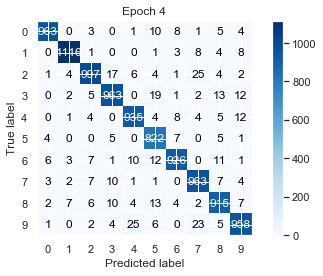

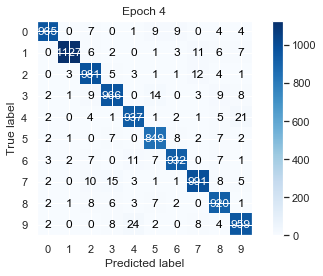

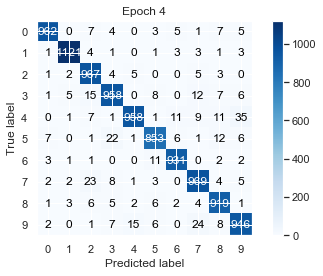

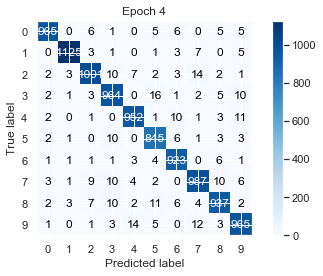

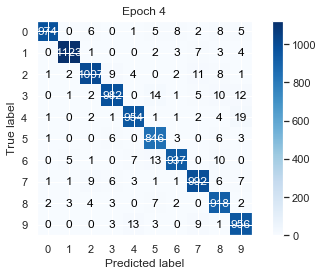

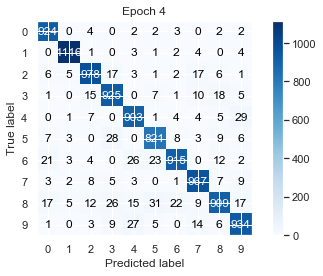

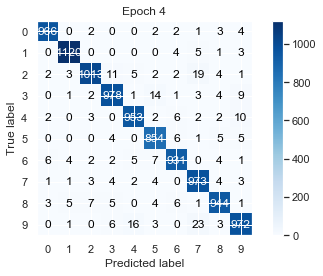

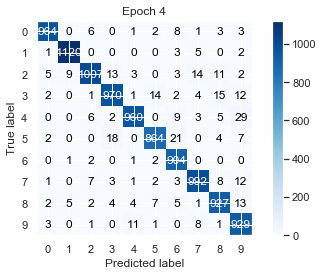

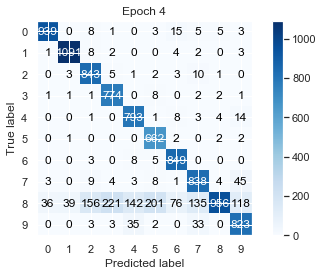

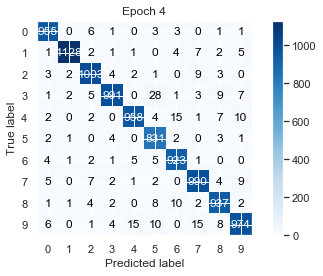

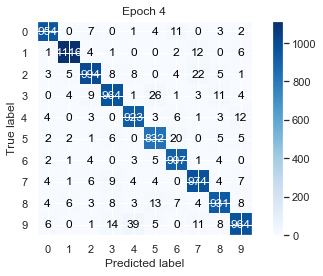

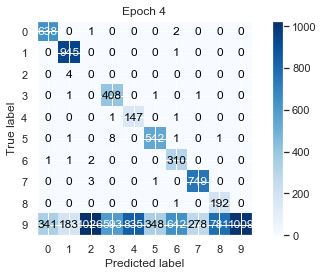

In [0]:
# expt_id = mlflow.create_experiment('Fixed nH')

mlflow.set_experiment('Fixed nH')

for lr in [0.01, 0.02, 0.05, 0.1]:
    for momentum in [0.9, 0.95, 0.99]:
        for hidden_nodes in [48]:
        
            expt_id = '%d_%d_%d' % (int(lr*100), int(momentum*100), hidden_nodes)

            print('\nLR = %.2f, Momentum = %.2f, Hidden nodes = %d\n' % (lr, momentum, hidden_nodes))

            model = Model(hidden_nodes)
            model.to(device)

            loss_fn = nn.CrossEntropyLoss()
            opt = optim.SGD(model.parameters(), lr=lr, momentum = momentum)

            with mlflow.start_run() as run:  
                for key, value in vars(args).items():
                    mlflow.log_param(key, value)
                mlflow.log_param('lr', lr)
                mlflow.log_param('momentum', momentum)
                mlflow.log_param('hidden_nodes', hidden_nodes)

                for epoch in range(1, args.epochs + 1):
                    train(epoch)
                    test(epoch)

                mlflow.pytorch.log_model(model, "models")

# Loading and visualising a model

In [0]:
# model_load = mlflow.pytorch.load_model('models', run_id="7fb32ab42dcb481fa0616cfc3aa0432b")

In [0]:
model_load = mlflow.pytorch.load_model('./mlruns/1/7fb32ab42dcb481fa0616cfc3aa0432b/artifacts/models/')

In [0]:
print(model_load)

Model(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): ReLU()
    (2): Linear(in_features=48, out_features=10, bias=True)
  )
)


In [0]:
weight_layer0 = list(model_load.parameters())[0].cpu().data.numpy()

In [0]:
print(weight_layer0.shape)

(48, 784)


In [0]:
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")

[]

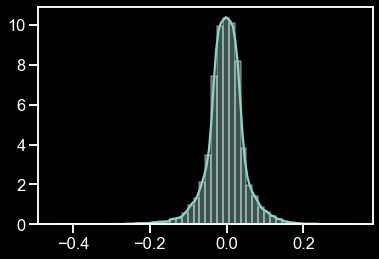

In [0]:
sns.distplot(weight_layer0.ravel())
plt.plot()

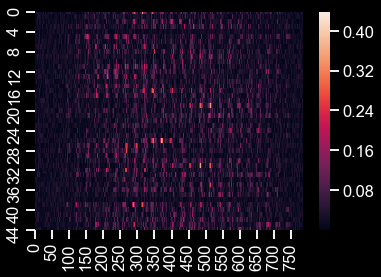

In [0]:
sns.heatmap(np.abs(weight_layer0))
plt.show()

In [0]:
weight_layer1 = list(model_load.parameters())[2].cpu().data.numpy()

In [0]:
weight_layer1.shape

(10, 48)

[]

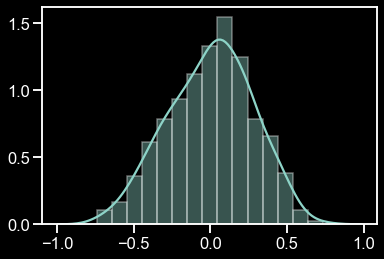

In [0]:
sns.distplot(weight_layer1.ravel())
plt.plot()

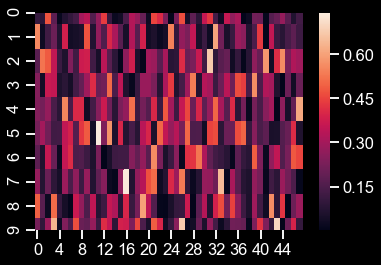

In [0]:
sns.heatmap(np.abs(weight_layer1))
plt.show()

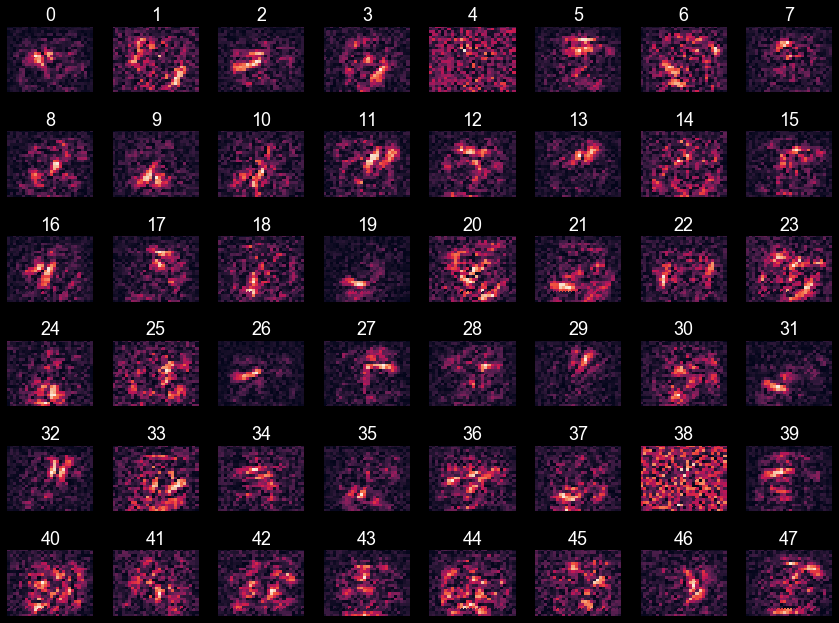

In [0]:
nrows = 6
ncols = 8
fig = plt.figure(figsize=(1.5*ncols, 1.5*nrows))

for i in np.arange(48): 
    ax1 = fig.add_subplot(nrows, ncols, i+1)
    sns.heatmap(np.abs((weight_layer0[i, 0:784]).reshape(28, 28)), ax = ax1, cbar=False)
    ax1.axis('off')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_title(i)
plt.tight_layout()
plt.show()